In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-data/customer_behavior_analytcis.csv


In [2]:
df = pd.read_csv("/kaggle/input/customer-data/customer_behavior_analytcis.csv")

In [3]:
df

,total_purchases,avg_cart_value,total_time_spent,product_click,discount_counts,customer_id
0,7.0,129.34,52.17,18.0,0.0,CM00000
1,22.0,24.18,9.19,15.0,7.0,CM00001
2,2.0,32.18,90.69,50.0,2.0,CM00002
3,25.0,26.85,11.22,16.0,10.0,CM00003
4,7.0,125.45,34.19,30.0,3.0,CM00004
...,...,...,...,...,...,...
994,5.0,64.64,72.70,50.0,1.0,CM00994
995,5.0,68.36,75.41,43.0,1.0,CM00995
996,18.0,19.53,28.77,18.0,8.0,CM00996
997,4.0,28.97,72.27,57.0,3.0,CM00997


In [4]:
df.isnull().sum()

total_purchases     20
avg_cart_value      20
total_time_spent     0
product_click       20
discount_counts      0
customer_id          0
dtype: int64

In [5]:
df["total_purchases"] = df["total_purchases"].fillna(df["total_purchases"].median())
df["avg_cart_value"] = df["avg_cart_value"].fillna(df["avg_cart_value"].median())
df["product_click"] = df["product_click"].fillna(df["product_click"].median())

In [6]:
from scipy.stats import zscore

z_scores = zscore(df[['total_purchases', 'avg_cart_value', 'product_click','total_time_spent','discount_counts']])

abs_z_scores = np.abs(z_scores)
outliers = (abs_z_scores > 3)

df = df[~outliers.any(axis=1)]

In [7]:
df.shape

(993, 6)

In [8]:
df = df.drop(columns=['customer_id'])

In [9]:
df.corr()

,total_purchases,avg_cart_value,total_time_spent,product_click,discount_counts
total_purchases,1.000000,-0.245809,-0.746455,-0.705883,0.746196
avg_cart_value,-0.245809,1.000000,-0.059420,-0.210321,-0.435557
total_time_spent,-0.746455,-0.059420,1.000000,0.856821,-0.668836
product_click,-0.705883,-0.210321,0.856821,1.000000,-0.573738
discount_counts,0.746196,-0.435557,-0.668836,-0.573738,1.000000


In [10]:
# df = df.drop(columns=['total_time_spent','discount_counts'])

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

In [12]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# df_scaled = scaler.fit_transform(df)

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import random

# Define the autoencoder
input_dim = df_scaled.shape[1]
encoding_dim = 4

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='linear')(encoded)

autoencoder = Model(input_layer, decoded)
encoder = Model(input_layer, encoded)

# Compile and train
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(df_scaled, df_scaled, epochs=50, batch_size=16, shuffle=True)


# Get the compressed features
df_encoded = encoder.predict(df_scaled)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1401  
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0943  
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0741
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0597
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 0.0534
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0462  
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0400  
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0343  
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - loss: 0.0315
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - loss: 0.0295
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - loss: 0.0250
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 0.0210
Epoch 13/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - loss: 0.0203
Epoch 14/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 0.0185
Epoch 15/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - loss: 

In [14]:
# from sklearn.cluster import KMeans

# kmeans = KMeans(n_clusters=3, max_iter=1000, n_init=10)
# df["cluster"] = kmeans.fit_predict(df_encoded)

# cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=df.columns[:-1])
# print("Cluster Centers:\n", cluster_centers)

# cluster_mapping = {
#     np.argmax(cluster_centers['total_purchases']): 'Bargain Hunters',
#     np.argmax(cluster_centers['avg_cart_value']): 'High Spenders',
#     np.argmax(cluster_centers['product_click']): 'Window Shoppers'
# }

# df['segment'] = df['cluster'].map(cluster_mapping)

In [15]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3,random_state=42 ,covariance_type='full', init_params='kmeans', max_iter=1000)
df['cluster'] = gmm.fit_predict(df_encoded)

In [16]:
# from sklearn.cluster import AgglomerativeClustering

# agg_clust = AgglomerativeClustering(n_clusters=3)
# df['cluster'] = agg_clust.fit_predict(df_scaled)

In [17]:
cluster_means = df.groupby("cluster").mean()
cluster_means

,total_purchases,avg_cart_value,total_time_spent,product_click,discount_counts
cluster,,,,,
0,19.480122,30.813456,17.396697,15.113150,9.807339
1,4.939940,49.035105,90.144865,49.285285,1.024024
2,10.171171,144.974084,40.389730,19.921922,1.945946


In [18]:
# from sklearn.cluster import DBSCAN

# best_eps = 4  # Adjust this value
# best_min_samples = 3  # Adjust this value

# # Apply DBSCAN
# dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
# df['cluster'] = dbscan.fit_predict(df_scaled)

In [19]:
# from sklearn.cluster import DBSCAN

# # Try different combinations of `eps` and `min_samples`
# eps_values = np.arange(0.5, 10.0, 0.5)  # Range of eps values
# min_samples_values = [3, 4, 5, 6]  # Different min_samples values

# # Loop through combinations and check cluster counts
# for eps in eps_values:
#     for min_samples in min_samples_values:
#         dbscan = DBSCAN(eps=eps, min_samples=min_samples)
#         df['cluster'] = dbscan.fit_predict(df_scaled)  # Assuming df_scaled is your normalized data

#         # Count the number of clusters excluding noise (-1)
#         num_clusters = len(set(df['cluster'])) - (1 if -1 in df['cluster'].values else 0)

#         if num_clusters == 3:
#             print(f"Found 3 clusters with eps={eps} and min_samples={min_samples}")

In [20]:
cluster_mapping = {}

max_total_purchases_cluster = df.groupby('cluster')['total_purchases'].max().idxmax()
cluster_mapping[max_total_purchases_cluster] = "Bargain Hunters"

max_avg_cart_value_cluster = df.groupby('cluster')['avg_cart_value'].max().idxmax()
cluster_mapping[max_avg_cart_value_cluster] = "High Spenders"

remaining_cluster = set(df['cluster'].unique()) - set(cluster_mapping.keys())
cluster_mapping[remaining_cluster.pop()] = "Window Shoppers"

df['segment'] = df['cluster'].map(cluster_mapping)

In [21]:
df = df.drop(columns=['cluster'])

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

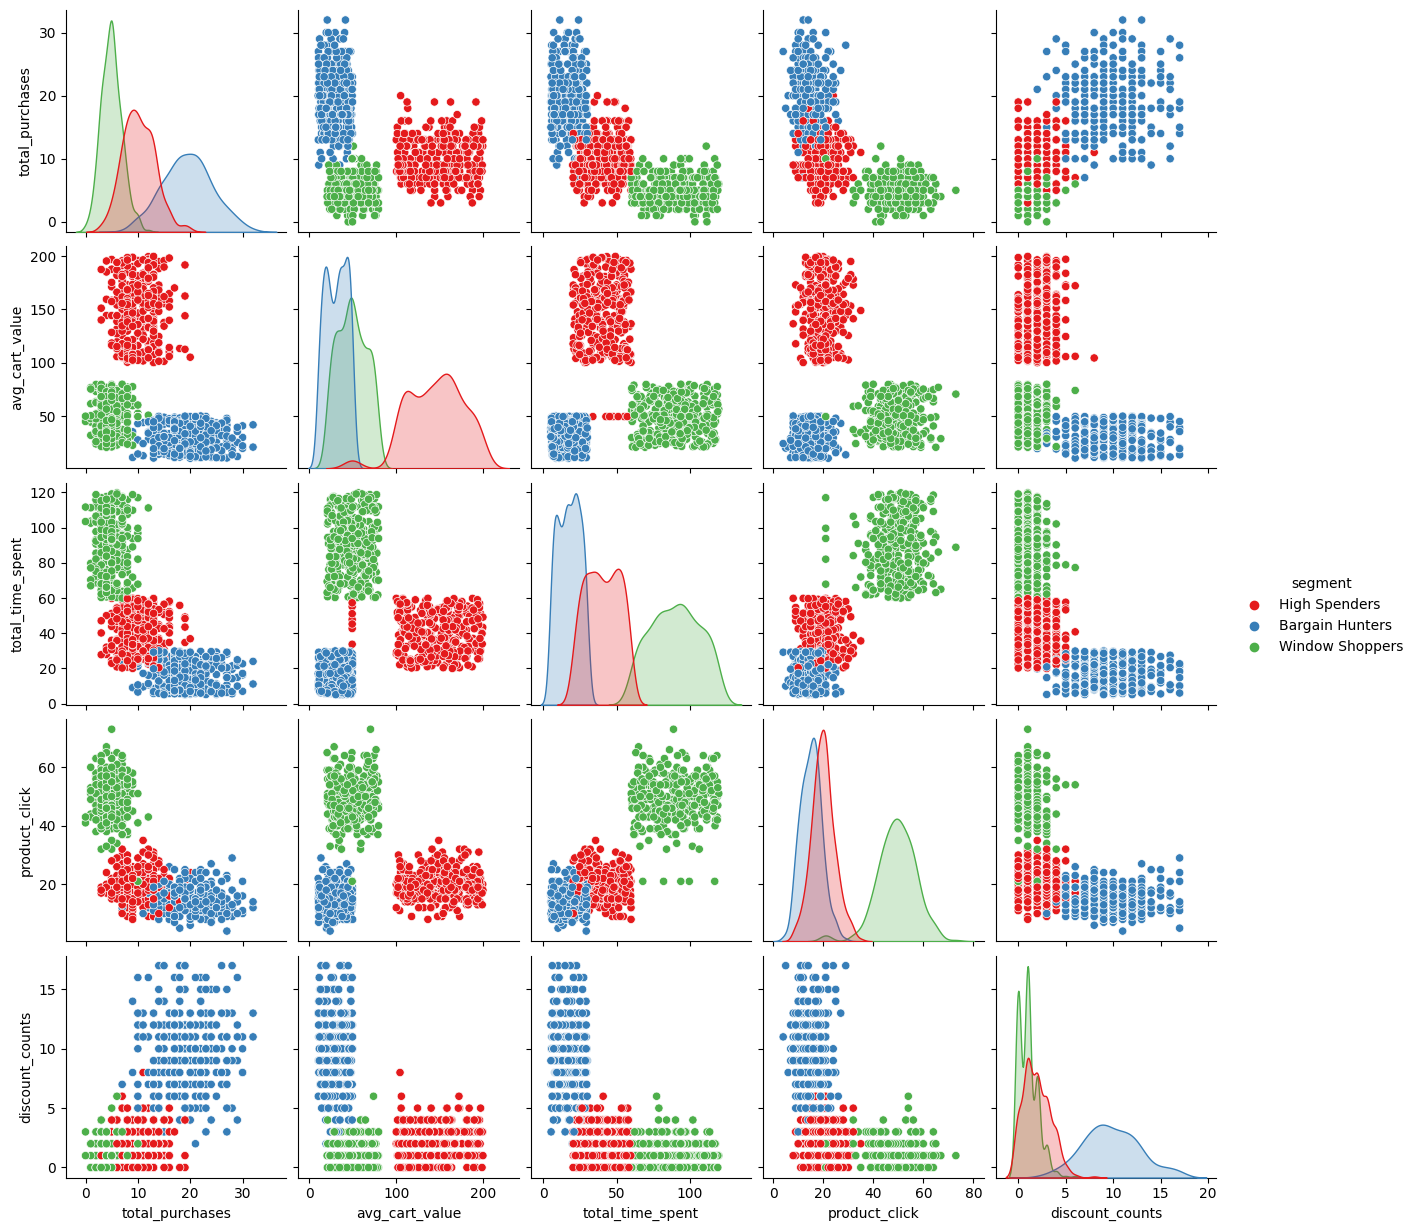

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.pairplot(df, hue='segment', palette="Set1")
plt.show()

In [23]:
from sklearn.metrics import silhouette_score

score = silhouette_score(df_encoded, df['segment'])
print(f"Silhouette Score: {score}")

Silhouette Score: 0.7447656393051147


In [24]:
from sklearn.metrics import davies_bouldin_score

features = df.drop(columns=['segment']) 
labels = df['segment']

dbi_score = davies_bouldin_score(features, labels)
print(f"Davies-Bouldin Index: {dbi_score}")

Davies-Bouldin Index: 0.4660621092177437
